In [1]:
import lensit as li
import numpy as np
import os 
import matplotlib.pyplot as plt
import copy
from scipy import stats, signal, interpolate

plt.rcParams['figure.figsize'] = [10, 5]

if not 'LENSIT' in os.environ.keys():
    os.environ['LENSIT'] = '_tmp'

In [2]:
# LDres = is the number of pixels of a side = 2^LDres, LDres=11 gives N = 2048
# HDres = physical size in arcmins = 0.74*2^HDres
# Final argument: num_threads defaults to 1 if there is no 'OMP_NUM_THREADS' env variable, this is threads used by pyFFTW
exp = 'SO'
LDres = 11
HDres = 11
nsims = 10
maps = li.get_maps_lib(exp, LDres, HDres=HDres, cache_lenalms=False, cache_maps=False, nsims=nsims)

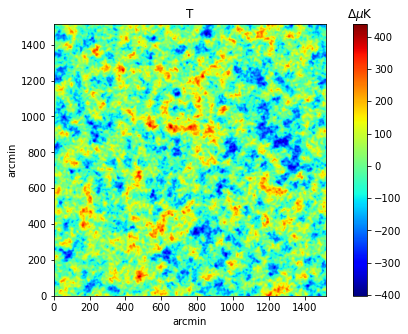

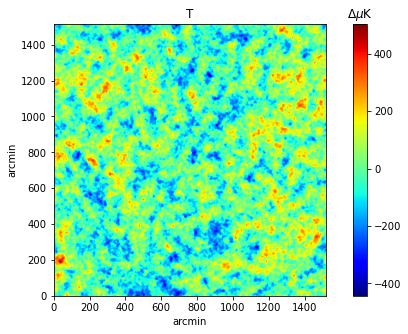

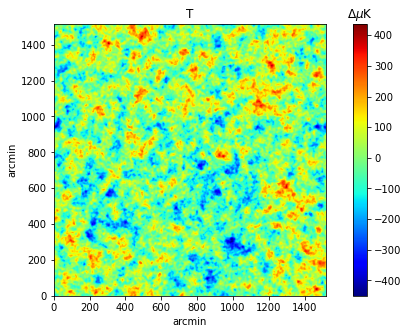

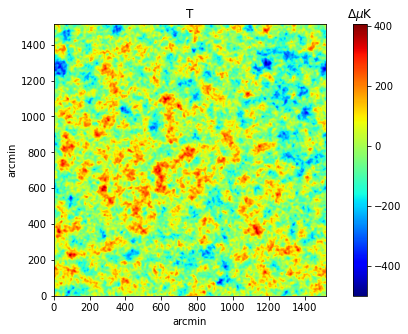

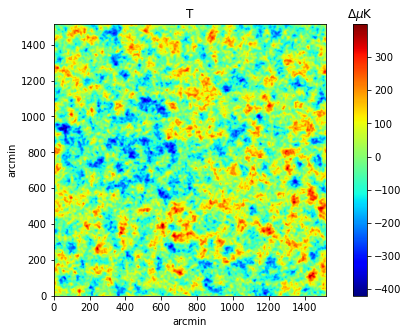

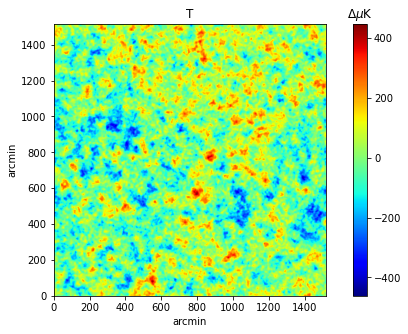

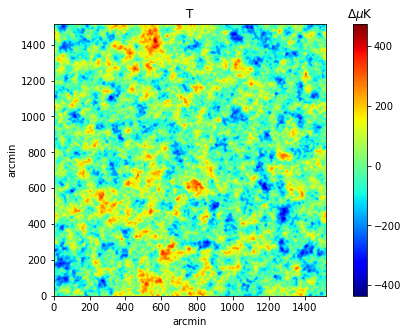

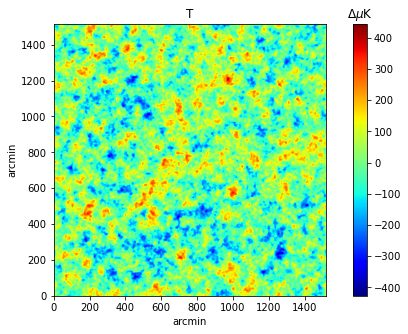

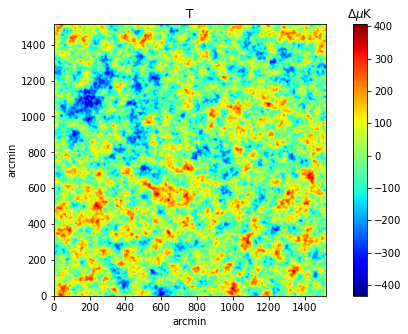

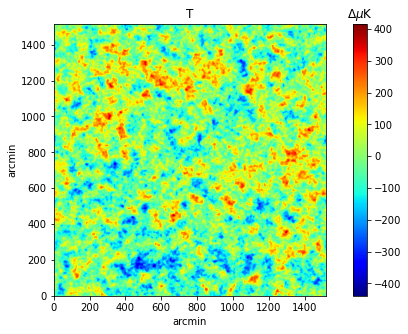

In [3]:
# HDres = 12 = 3000 arcmin = 50deg = 12000Mpc
# HDres = 11 = 2000 arcmin = 33deg = 8000Mpc
# HDres = 10 = 1000 arcmin = 17deg = 4000Mpc

# Calculating physical scale of sky patch in arcmins
physical_scale = 0.74*2**HDres  # In arcmin
extent = [0, physical_scale, 0, physical_scale]

#Plotting all simulated T maps
for iii in range(nsims):
    Tmap = maps.get_sim_tmap(iii)
    plt.figure()
    plt.imshow(Tmap, extent=extent, cmap='jet')
    plt.ylabel('arcmin')
    plt.xlabel('arcmin')
    plt.title('T')
    plt.colorbar().ax.set_title('$\Delta\mu$K')
plt.show()

In [4]:
# Splined CAMB Cls for Chi square test
ellmax = 6000
Cl_unlensed, Cl_lensed = li.get_fidcls(ellmax_sky=ellmax)
ells = np.arange(ellmax + 1)
Cl_unlensed_spl = interpolate.InterpolatedUnivariateSpline(ells, Cl_unlensed['tt'])
Cl_lensed_spl = interpolate.InterpolatedUnivariateSpline(ells, Cl_lensed['tt'])

In [5]:
def get_chisquare(ell_binned, ps_binned, errors, lensed=True):
    """
    Calculates the reduced chi square
    
    chi^2 = sum_i((O_i - E_i)^2/var)
    chi^2_reduced = chi^2/dof
    """
    if lensed:
        camb_Cl = Cl_lensed_spl(ell_binned)
    else:
        camb_Cl = Cl_unlensed_spl(ell_binned)
    
    # Expected value
    camb_ps = camb_Cl*ell_binned*(ell_binned+1)/(2*np.pi)
    
    # Set denominator to the variance. If variance is 0, set it to expected value
    #denom = np.array([std**2 if std > 0. else camb_ps[iii] for iii, std in enumerate(stds)])
    denom = np.array([err**2 if err > 0. else camb_ps[iii] for iii, err in enumerate(errors)])
    
    # Degrees of freedom
    dof = (np.size(ell_binned) - 1)
    
    return np.sum((ps_binned - camb_ps)**2/denom)/dof

def get_ps(lib, alm):
    """
    calculates power spectrum
    
    lib is instance of ffs_covs.ell_mat.ffs_alm_pyFFTW
    alm can be extracted from instances of sims.ffs_cmbs.sims_cmb_len.(unlcmbs).get_sim_<desired_alm>(<index>)
    return ell and ps for values of ell where ps > 0
    """
    # Convert alm into Cl (power spectrum)
    Cl = lib.alm2cl(alm)

    # For some reason, some Cl values are 0 (this due to no. of pixels?), this extracts the index at which Cl is not 0
    ell = np.where(Cl > 0.)[0] # indices at which ps is not 0, ell=indices

    # Calculating Cl*l*(l+1)/(2*pi)
    ps = Cl[ell]*ell*(ell+1)/(2*np.pi)
    
    return ell, ps

    
def get_binned_ps(lib, alm, Nbins):
    """
    calculates power spectrum and bins it
    
    lib is instance of ffs_covs.ell_mat.ffs_alm_pyFFTW
    alm can be extracted from instances of sims.ffs_cmbs.sims_cmb_len.(unlcmbs).get_sim_<desired_alm>(<index>)
    returns binned ell and ps for values of ell where ps > 0
    """
    ell, ps = get_ps(lib, alm)
    
    # Take the means of binned ps for cleaner plot
    means, bin_edges, binnumber = stats.binned_statistic(ell, ps, 'mean', bins=Nbins)
    counts, *others = stats.binned_statistic(ell, ps, 'count', bins=Nbins)
    stds, *others = stats.binned_statistic(ell, ps, 'std', bins=Nbins)
    errors = stds/np.sqrt(counts)
    
    binSeperation = bin_edges[1]
    ellBins = np.asarray([bin_edges[i] - binSeperation/2 for i in range(1, len(bin_edges))])
    return ellBins, means, errors, stds

def plot_ps(ell, ps, errors, title, camb=None, field='t'):
    """
    Plots power spectrum. If camb is not None, fiducial ps also plotted for given field.
    """
    plt.figure()
    plt.plot(ell, ps, '.', label=("Simulated"), ls='none', c='royalblue')
    plt.errorbar(ell, ps, yerr=errors, ls='none', c='royalblue')
    plt.title(title)
    plt.xlabel("$\ell$")
    plt.ylabel("$(\ell + 1)\ell C_l/2\pi$ $[\mu$K$^2]$")
    
    if camb is not None:
        ellmax = int(np.max(ell))
        ell_camb = np.arange(1,ellmax)
        camb_Cl_unlensed, camb_Cl_lensed = li.get_fidcls(ellmax_sky = ellmax)
        if camb == "unlensed":
            plt.plot(ell_camb, camb_Cl_unlensed[field+field][ell_camb]*ell_camb*(ell_camb + 1)/(2*np.pi), label="CAMB unlensed", c='r')
        elif camb == "lensed":
            plt.plot(ell_camb, camb_Cl_lensed[field+field][ell_camb]*ell_camb*(ell_camb + 1)/(2*np.pi), label="CAMB lensed", c='lime')
        elif camb == "both":
            plt.plot(ell_camb, camb_Cl_unlensed[field+field][ell_camb]*ell_camb*(ell_camb + 1)/(2*np.pi), label="CAMB unlensed", c='r')
            plt.plot(ell_camb, camb_Cl_lensed[field+field][ell_camb]*ell_camb*(ell_camb + 1)/(2*np.pi), label="CAMB lensed", c='lime')
            
        plt.legend()
    
def plot_log_ps(ell, ps, errors, title, camb=None, field='t'):
    """
    Plots logarithmic power spectrum. If camb is not None, fiducial ps also plotted for given field.
    """
    plt.figure()
    plt.plot(ell, ps, '.', label=("Simulated"), ls='none', c='royalblue')
    plt.errorbar(ell, ps, yerr=errors, ls='none', c='royalblue')
    plt.title(title)
    plt.xlabel("$\ell$")
    plt.ylabel("$(\ell + 1)\ell C_l/2\pi$ $[\mu$K$^2]$")
    
    if camb is not None:
        ellmax = int(np.max(ell))
        ell_camb = np.arange(1,ellmax)
        camb_Cl_unlensed, camb_Cl_lensed = li.get_fidcls(ellmax_sky = ellmax)
        if camb == "unlensed":
            plt.loglog(ell_camb, camb_Cl_unlensed[field+field][ell_camb]*ell_camb*(ell_camb + 1)/(2*np.pi), label="CAMB unlensed", c='r')
        elif camb == "lensed":
            plt.loglog(ell_camb, camb_Cl_lensed[field+field][ell_camb]*ell_camb*(ell_camb + 1)/(2*np.pi), label="CAMB lensed", c='lime')
        elif camb == "both":
            plt.loglog(ell_camb, camb_Cl_unlensed[field+field][ell_camb]*ell_camb*(ell_camb + 1)/(2*np.pi), label="CAMB unlensed", c='r')
            plt.loglog(ell_camb, camb_Cl_lensed[field+field][ell_camb]*ell_camb*(ell_camb + 1)/(2*np.pi), label="CAMB lensed", c='lime')
            
        plt.legend()

Reduced Chi square lensed = 51421.75072920821
Reduced Chi square unlensed = 2.0400114743091984


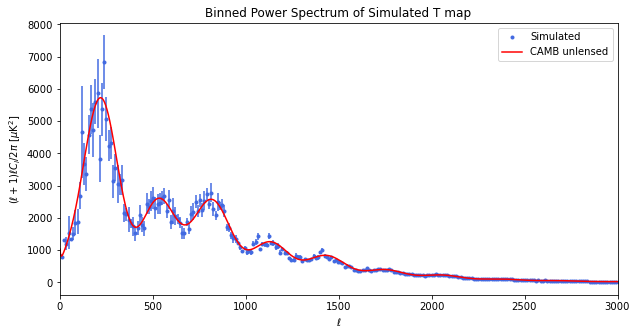

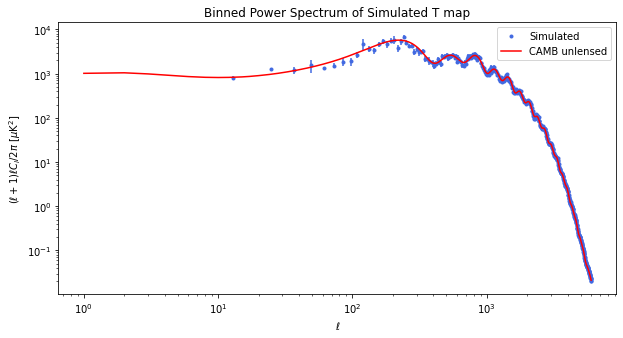

In [6]:
# This is apparently the best route to getting the unlensed library
lib_unlensed = maps.lencmbs.unlcmbs.lib_skyalm

# Get the alm from the unlensed T field at index iii (Cl = <|alm|^2>)
T_alm = maps.lencmbs.unlcmbs.get_sim_tlm(iii)

# Calculate powerspectrum (my function)
Nbins = 500
ell_binned, ps_binned, errors, stds = get_binned_ps(lib_unlensed, T_alm, Nbins)

# Plot (my functions)
plot_ps(ell_binned, ps_binned, errors, "Binned Power Spectrum of Simulated T map", camb="unlensed")
plt.xlim(0,3000)
plot_log_ps(ell_binned, ps_binned, errors, "Binned Power Spectrum of Simulated T map", camb="unlensed")

# Comapre Chi square of lensed and unlensed camb models
chi_unlensed = get_chisquare(ell_binned, ps_binned, errors, lensed=False)
chi_lensed = get_chisquare(ell_binned, ps_binned, errors, lensed=True)
print(f"Reduced Chi square lensed = {chi_lensed}")
print(f"Reduced Chi square unlensed = {chi_unlensed}")

<ipython-input-5-42184cc3bf70>:59: RuntimeWarning: invalid value encountered in true_divide
  errors = stds/np.sqrt(counts)


Reduced Chi square lensed = 282098.81374541356
Reduced Chi square unlensed = 2.9880964953416145


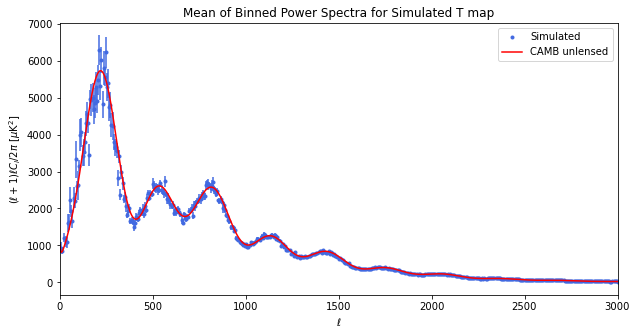

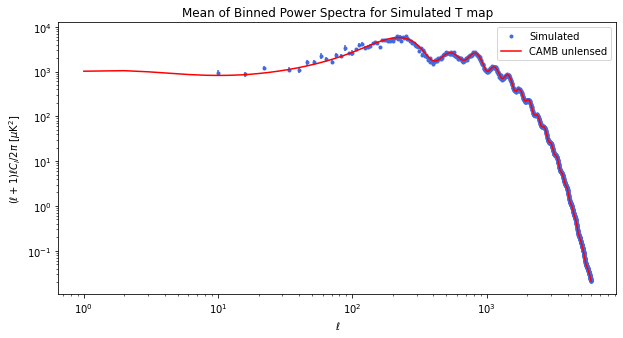

In [7]:
# Here taking the mean power spectrum from 10 simulations 

Nbins=1000

# calculating the poswer spectrum of the 0th simulation
T_alm_0 = maps.lencmbs.unlcmbs.get_sim_tlm(0)
ell_binned, ps_binned_0, errors, stds = get_binned_ps(lib_unlensed, T_alm_0, Nbins)

# Looping over remaining simulations and summing the binned power spectra
PSs = np.zeros((nsims, Nbins))
PSs[0,:] = ps_binned_0
for iii in range(1, nsims):
    T_alm = maps.lencmbs.unlcmbs.get_sim_tlm(iii)
    ell_binned, ps_binned, errors, stds = get_binned_ps(lib_unlensed, T_alm, Nbins)
    PSs[iii,:] = ps_binned

# Calculating mean and standard errors
mean_ps_binned = np.array([np.mean(PSs[:, col]) for col in range(Nbins)])
stds = np.array([np.std(PSs[:, col]) for col in range(Nbins)])
errors = stds/np.sqrt(nsims)

# Plotting
plot_ps(ell_binned, mean_ps_binned, errors, "Mean of Binned Power Spectra for Simulated T map", camb="unlensed")
plt.xlim(0,3000)
plot_log_ps(ell_binned, mean_ps_binned, errors, "Mean of Binned Power Spectra for Simulated T map", camb="unlensed")

# Comapre Chi square of lensed and unlensed camb models
chi_unlensed = get_chisquare(ell_binned[4:], mean_ps_binned[4:], errors[4:], lensed=False)
chi_lensed = get_chisquare(ell_binned[4:], mean_ps_binned[4:], errors[4:], lensed=True)
print(f"Reduced Chi square lensed = {chi_lensed}")
print(f"Reduced Chi square unlensed = {chi_unlensed}")

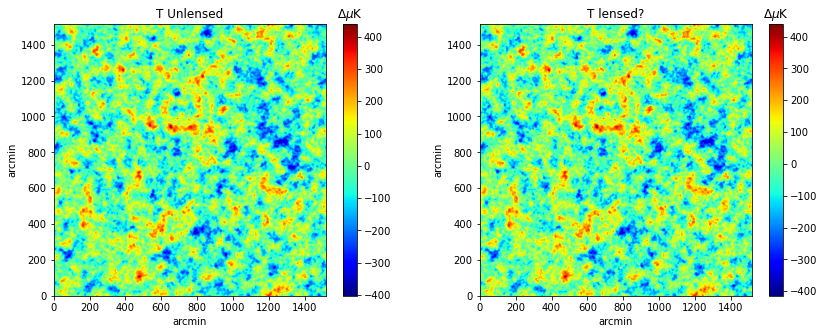

(2048, 2048)
(2048, 2048)
18692034.25278578


In [8]:
# First attempt at plotting lensed T map (This was attempted without recalculating anything) - doesn't look successful

# lensed library
lib_lensed = maps.lencmbs.lib_skyalm

# Get lensed map
T_alm_lensed_0 = maps.lencmbs.get_sim_tlm(0)            # T_alm_lensed_0 = maps.lencmbs.get_sim_alm(0,'t')   (another option) 
Tmap_lensed_0 = lib_lensed.alm2map(T_alm_lensed_0)

# Get unlensed map
Tmap_0 = maps.get_sim_tmap(0)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

im0 = ax[0].imshow(Tmap_0, extent=extent, cmap='jet')
ax[0].set_ylabel('arcmin')
ax[0].set_xlabel('arcmin')
ax[0].set_title('T Unlensed')
plt.colorbar(im0, ax=ax[0]).ax.set_title('$\Delta\mu$K')
                       
im1 = ax[1].imshow(Tmap_lensed_0, extent=extent, cmap='jet')
ax[1].set_ylabel('arcmin')
ax[1].set_xlabel('arcmin')
ax[1].set_title('T lensed?')
plt.colorbar(im1, ax=ax[1]).ax.set_title('$\Delta\mu$K')
plt.show()

print(np.shape(Tmap_0))
print(np.shape(Tmap_lensed_0))
print(np.sum(np.abs(Tmap_0 - Tmap_lensed_0)))

Reduced Chi square lensed = 16.402029745017973
Reduced Chi square unlensed = 284.2767186774402


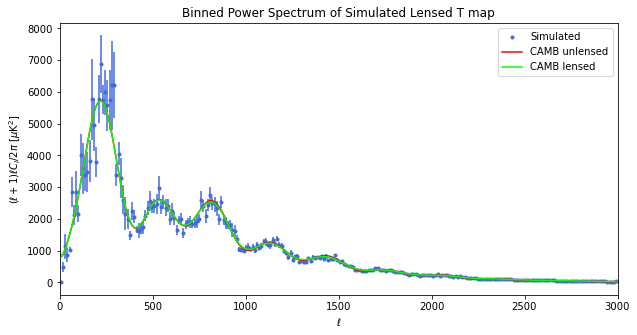

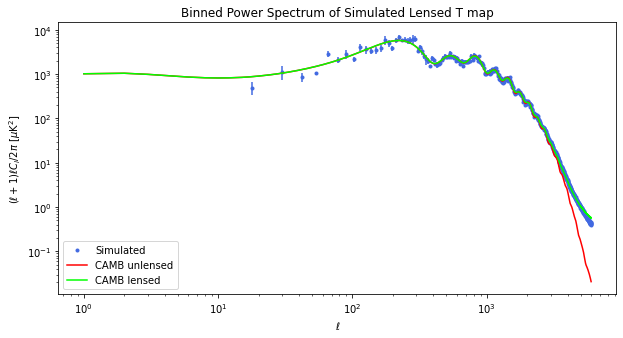

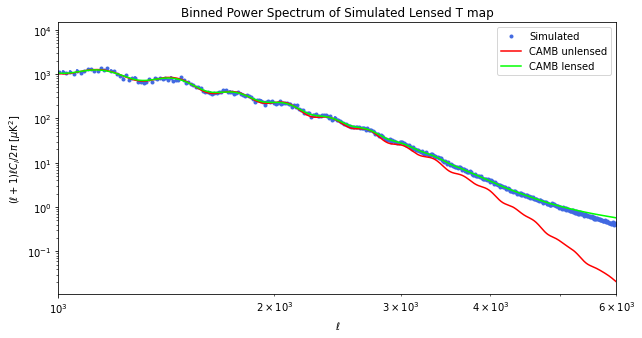

In [9]:
# Plotting lensed power spectrum 

Nbins = 500

# Calculate powerspectrum (my function)
ell_binned_lensed, ps_binned_lensed_0, errors, stds = get_binned_ps(lib_lensed, T_alm_lensed_0, Nbins)

# Plot (my functions)
plot_ps(ell_binned_lensed, ps_binned_lensed_0, errors, "Binned Power Spectrum of Simulated Lensed T map", camb="both")
plt.xlim(0,3000)
plot_log_ps(ell_binned_lensed, ps_binned_lensed_0, errors, "Binned Power Spectrum of Simulated Lensed T map", camb="both")
plot_log_ps(ell_binned_lensed, ps_binned_lensed_0, errors, "Binned Power Spectrum of Simulated Lensed T map", camb="both")
plt.xlim(1000, 6000)

# Comapre Chi square of lensed and unlensed camb models
chi_unlensed = get_chisquare(ell_binned_lensed, ps_binned_lensed_0, errors, lensed=False)
chi_lensed = get_chisquare(ell_binned_lensed, ps_binned_lensed_0, errors, lensed=True)
print(f"Reduced Chi square lensed = {chi_lensed}")
print(f"Reduced Chi square unlensed = {chi_unlensed}")

<ipython-input-5-42184cc3bf70>:59: RuntimeWarning: invalid value encountered in true_divide
  errors = stds/np.sqrt(counts)


Reduced Chi square lensed = 9.778078299966216
Reduced Chi square unlensed = 198.70562300093465


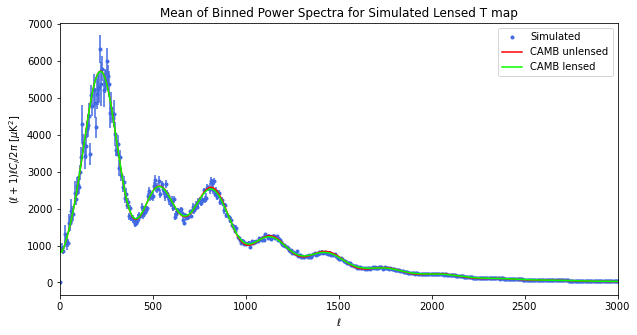

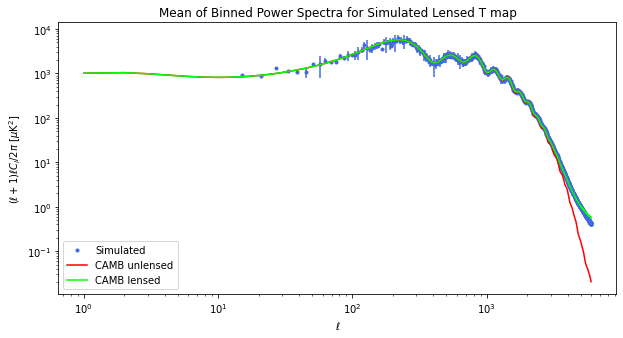

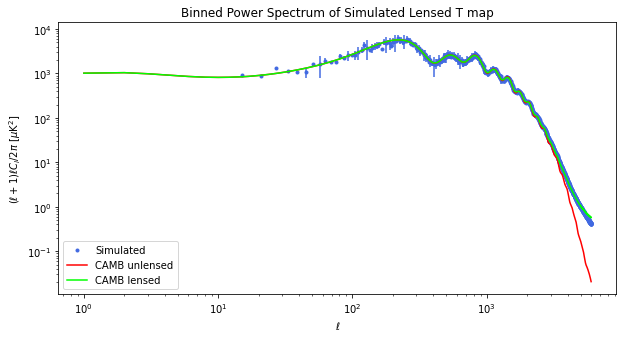

In [10]:
# Here taking the mean power spectrum from 10 lensed simulations 

Nbins = 1000

T_alm_lensed_0 = maps.lencmbs.get_sim_tlm(0)
ell_binned_lensed, ps_binned_lensed_0, errors, stds_lensed = get_binned_ps(lib_lensed, T_alm_lensed_0, Nbins)

# Looping over remaining simulations and summing the binned power spectra
PSs_lensed = np.zeros((nsims, Nbins))
PSs_lensed[0,:] = ps_binned_lensed_0
for iii in range(1, nsims):
    T_alm_lensed = maps.lencmbs.get_sim_tlm(iii)
    ell_binned_lensed, ps_binned_lensed, errors, stds_lensed = get_binned_ps(lib_lensed, T_alm_lensed, Nbins)
    PSs_lensed[iii,:] = ps_binned_lensed

# Calculating mean and standard errors
mean_ps_binned_lensed = np.array([np.mean(PSs_lensed[:, col]) for col in range(Nbins)])
stds_lensed = np.array([np.std(PSs_lensed[:, col]) for col in range(Nbins)])
errors_lensed = stds_lensed/np.sqrt(nsims)


# Plotting
plot_ps(ell_binned_lensed, mean_ps_binned_lensed, errors_lensed, "Mean of Binned Power Spectra for Simulated Lensed T map", camb="both")
plt.xlim(0,3000)
plot_log_ps(ell_binned_lensed, mean_ps_binned_lensed, errors, "Mean of Binned Power Spectra for Simulated Lensed T map", camb="both")
plot_log_ps(ell_binned_lensed, mean_ps_binned_lensed, errors, "Binned Power Spectrum of Simulated Lensed T map", camb="both")
#plt.xlim(1000, 6000)

# Comapre Chi square of lensed and unlensed camb models
chi_unlensed = get_chisquare(ell_binned_lensed[4:], mean_ps_binned_lensed[4:], errors[4:], lensed=False)
chi_lensed = get_chisquare(ell_binned_lensed[4:], mean_ps_binned_lensed[4:], errors[4:], lensed=True)
print(f"Reduced Chi square lensed = {chi_lensed}")
print(f"Reduced Chi square unlensed = {chi_unlensed}")

In [11]:
# Smoothing function
def gaussian_smooth_1d(data, sigma, nsigma=5):
    win = signal.gaussian(nsigma * sigma, std=sigma)
    res = np.convolve(data, win, mode='same')
    return res / np.convolve(np.ones(data.shape), win, mode='same')

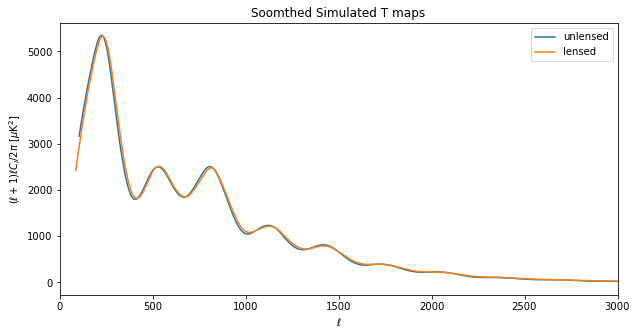

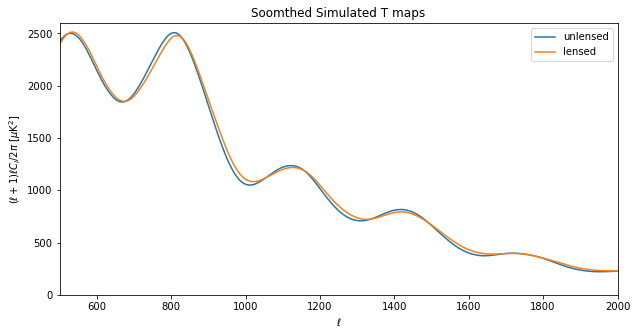

(1.0, -1.0)

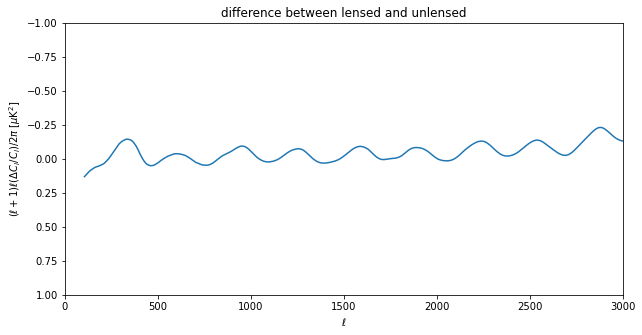

In [17]:
# Compare smoothed simulations of lensed and unlensed spectra

# Smoothing the mean spectra of lensed and unlensed simulated T maps
mean_ps_binned_smoothed = gaussian_smooth_1d(mean_ps_binned, 5)
mean_ps_binned_lensed_smoothed = gaussian_smooth_1d(mean_ps_binned_lensed, 5)

# Plotting
plt.figure()
plt.plot(ell_binned, mean_ps_binned_smoothed, label="unlensed")
plt.plot(ell_binned_lensed, mean_ps_binned_lensed_smoothed, label="lensed")
plt.xlabel("$\ell$")
plt.ylabel("$(\ell + 1)\ell C_l/2\pi$ $[\mu$K$^2]$")
plt.title("Soomthed Simulated T maps")
plt.legend()
plt.xlim(0, 3000)

# Zoomed plot
plt.figure()
plt.plot(ell_binned, mean_ps_binned_smoothed, label="unlensed")
plt.plot(ell_binned_lensed, mean_ps_binned_lensed_smoothed, label="lensed")
plt.xlabel("$\ell$")
plt.ylabel("$(\ell + 1)\ell C_l/2\pi$ $[\mu$K$^2]$")
plt.title("Soomthed Simulated T maps")
plt.legend()
plt.xlim(500, 2000)
plt.ylim(0,2600)
plt.show()

# Difference
plt.figure()
ps_diff = mean_ps_binned_smoothed - mean_ps_binned_lensed_smoothed
plt.plot(ell_binned, ps_diff/mean_ps_binned_smoothed)
plt.xlabel("$\ell$")
plt.ylabel("$(\ell + 1)\ell (\Delta C_l/C_l)/2\pi$ $[\mu$K$^2]$")
plt.title("difference between lensed and unlensed")
plt.xlim(0, 3000)
plt.ylim(1, -1)